Imports for VGG19 : 

In [88]:
# import cv2
import torch
import torch.nn as nn
from torchvision.models import vgg19
from torchvision.models import VGG19_Weights
import numpy as np

Other imports (from pytorch Lime tutorial)

In [89]:
import matplotlib.pyplot as plt
from PIL import Image
import os, json
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

Get the image : 

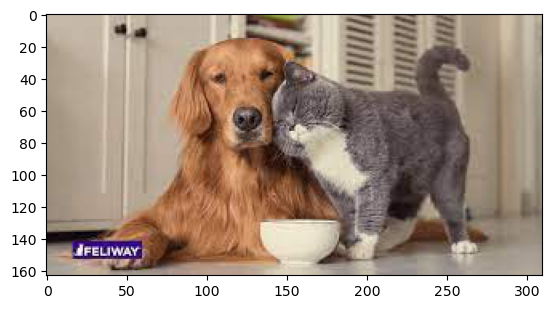

In [102]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image('./Images/Chat&Chien.jpeg')
plt.imshow(img)

-----

Resize & Normalize the image : 

In [103]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

Get the model with default weights : 

In [104]:
model = vgg19(weights=models.VGG19_Weights.DEFAULT)

Get all the labels and class index that are possible for a prediction : 

In [105]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('./imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}   

In [107]:
def new_predict_fn(images):
   images = skimage_to_vgg(images)
   return predict_fn(images)

Get the top 5 predictions from VGG19 :

In [108]:
img_t = get_input_tensors(img)
model.eval()
logits = model(img_t)
probs = F.softmax(logits, dim=1)
probs5 = probs.topk(5)
tuple((p,c, idx2label[c]) for p, c in zip(probs5[0][0].detach().numpy(), probs5[1][0].detach().numpy()))

((0.24847443, 207, 'golden_retriever'),
 (0.24426273, 220, 'Sussex_spaniel'),
 (0.042997025, 168, 'redbone'),
 (0.03758685, 219, 'cocker_spaniel'),
 (0.033973962, 175, 'otterhound'))

Normalize the picture (?)

In [109]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [110]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Get the number associated with the top predicted class : 

In [111]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax() # le numéro renvoyé est le num correspondant dans le imagenet_class_index

207

Import LIME : 

In [112]:
from lime import lime_image

Get LIME's explanations for the picture : 

In [113]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

In [114]:
from skimage.segmentation import mark_boundaries

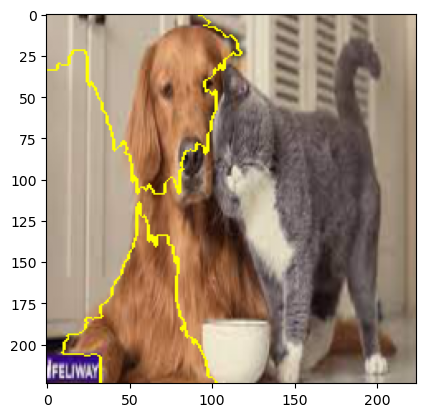

In [115]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

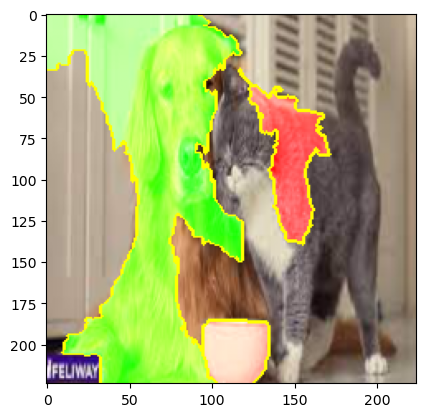

In [116]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)